In [1]:
import itertools as it
import numpy as np
import cvxpy as cvx
import scipy.optimize as opt
from scipy.spatial.distance import pdist,cdist,squareform

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [3]:
y = np.array([-1,-1,-1,1,1,1])
x1 = np.array([-1.5,-0.5,-0.5,0.5,0.5,1.5])
x2 = np.array([-0.5,-0.5,-1.5,0.5,1.5,0.5])
X = np.array([x1,x2]).T
X = np.column_stack((X,np.ones(len(y))))

In [4]:
# Solve SVM
q = cvx.Variable(3)
objective = cvx.Minimize(1/2*cvx.norm(q)**2)
constraints = [cvx.mul_elemwise(y,X*q+cvx_b)>=1]
prob = cvx.Problem(objective,constraints)
result = prob.solve()
q = q.value.A1

NameError: name 'cvx_b' is not defined

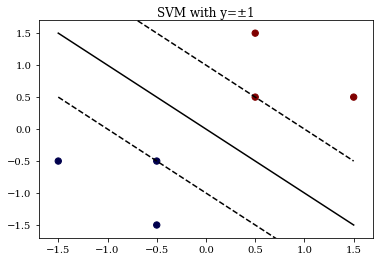

In [700]:
# Plot SVM
q1,q2,b = q
# b = cvx_b.value
plt.scatter(X[:,0],X[:,1],c=y,s=40*np.abs(y),cmap='seismic');
s = np.linspace(min(x1),max(x1),10)
plt.plot(s,1/q2*(-b-q1*s),'k')
plt.plot(s,1/q2*(-1-b-q1*s),'k--')
plt.plot(s,1/q2*(1-b-q1*s),'k--')
plt.axis(xmin=-1.7,xmax=1.7,ymax=1.7,ymin=-1.7)
plt.title('SVM with y=±1');

In [702]:
# Solve primal
r = np.array([-1,-2,-1,1,2,1])
n = len(r)
risk_neutral = lambda x: x
exp_utility = lambda x: -cvx.exp(-5*x)
u = exp_utility
q = cvx.Variable(3)
objective = cvx.Maximize(
    1/(1*n)*cvx.sum_entries(u(cvx.mul_elemwise(r,X*q+cvx_b))) -
    1*(cvx.norm(q)**2+cvx_b**2))
prob = cvx.Problem(objective)
prob.solve()
q = q.value.A1

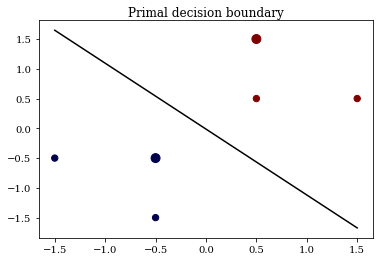

In [703]:
# Plot primal
q1,q2,b = q
# b = cvx_b.value
plt.scatter(X[:,0],X[:,1],c=np.where(r>0,1,-1),s=40*np.abs(r),cmap='seismic')
s = np.linspace(min(x1),max(x1),10)
plt.plot(s,1/q2*(-b-q1*s),'k');
# plt.plot(s,1/q2*(0.5-b-q1*s),'k--');
# plt.plot(s,1/q2*(-0.5-b-q1*s),'k--');
plt.title('Primal decision boundary');

In [7]:
r = np.array([-1,-2,-1,1,2,2,-2])
x1 = np.array([-1.5,-0.5,-0.5,0.5,0.5,1.5,0])
x2 = np.array([-0.5,-0.5,-1.5,0.5,1.5,0.5,2])
X = np.array([x1,x2]).T
X = np.column_stack((X,np.ones(len(r))))

In [8]:
# ker = lambda x,y: (np.inner(x,y) + 1)**3
# ker = lambda x,y: np.tanh(0.01*np.inner(x,y))
# ker = lambda x,y: np.exp(-np.inner(x-y,x-y))
# ker = lambda x,y: np.exp(np.inner(x,y))

In [9]:
# K = np.exp(-squareform(pdist(X))**2/25)

In [10]:
def quad_K(X1,X2=None):
    if X2 is None:
        X2 = X1
    K = (np.inner(X1,X2)+1)**3
    return K

sigma = 1
def gauss_K(X1,X2=None):
    if X2 is None:
        K = np.exp(-squareform(pdist(X1))**2/sigma)
        return K
    else:
        K = np.exp(-cdist(X1,X2)**2/sigma).T
        return K

In [11]:
# Solve dual
# K = quad_K(X)
K = gauss_K(X)
a = cvx.Variable(len(r))
ra = cvx.mul_elemwise(r,a)
objective = -cvx.sum_entries(cvx.kl_div(a,1)) - 0.1*cvx.quad_form(ra,K)
prob = cvx.Problem(cvx.Maximize(objective))
prob.solve()
a = a.value.A1

In [13]:
X,r

(array([[-1.5, -0.5,  1. ],
        [-0.5, -0.5,  1. ],
        [-0.5, -1.5,  1. ],
        [ 0.5,  0.5,  1. ],
        [ 0.5,  1.5,  1. ],
        [ 1.5,  0.5,  1. ],
        [ 0. ,  2. ,  1. ]]), array([-1, -2, -1,  1,  2,  2, -2]))

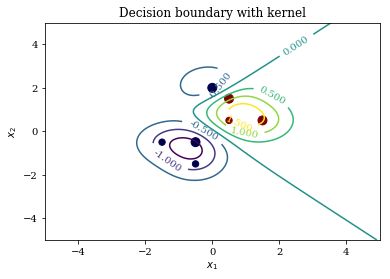

In [14]:
delta = 500
xx1 = np.linspace(-5,5,delta)
xx2 = np.linspace(-5,5,delta)
X_s = np.array(np.meshgrid(xx1,xx2,[1])).T[0].reshape((delta*delta,3))
phi = gauss_K(X,X_s)
Z = np.inner(phi,a*r).reshape((delta,delta)).T
plt.scatter(X[:,0],X[:,1],c=np.where(r>0,1,-1),s=40*np.abs(r),cmap='seismic');
cont = plt.contour(xx1,xx2,Z)
plt.clabel(cont)
plt.title('Decision boundary with kernel');
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');

In [15]:
X_s

array([[-5.        , -5.        ,  1.        ],
       [-5.        , -4.97995992,  1.        ],
       [-5.        , -4.95991984,  1.        ],
       ..., 
       [ 5.        ,  4.95991984,  1.        ],
       [ 5.        ,  4.97995992,  1.        ],
       [ 5.        ,  5.        ,  1.        ]])

In [27]:
X,r
n,p = X.shape

In [32]:
K = np.inner(X,X)

In [33]:
ell = lambda r: cvx.exp(-r)
ell_star = lambda r: cvx.kl_div(-r,1)-1

In [34]:
# Probleme primal
q = cvx.Variable(p)
obj = cvx.sum_entries(ell(cvx.mul_elemwise(r,X*q))) + n*cvx.norm(q)**2
prob = cvx.Problem(cvx.Minimize(obj))
v1 = prob.solve(solver=cvx.CVXOPT)
obj.value

5.7534267124747593

In [35]:
# Probleme dual
a = cvx.Variable(n)
ra = cvx.mul_elemwise(r,a)
obj = cvx.sum_entries(ell_star(a)) + 1/(4*n)*cvx.quad_form(ra,K)
prob = cvx.Problem(cvx.Minimize(obj))
v2 = prob.solve(solver=cvx.CVXOPT)
obj.value

-5.7534267124745195

In [36]:
# valeur de q a partir de a
-1/(2*n)*np.dot(X.T,r*a.value.A1)

array([ 0.30807215,  0.05886651, -0.09023284])

In [38]:
# Valeur de q dans le primal
q.value.A1

array([ 0.30807202,  0.05886648, -0.09023284])

In [25]:
obj = cvx.sum_entries(ell(cvx.mul_elemwise(r,X*q))) + cvx.norm(X*q)**2 + n*cvx.norm(q)**2
prob = cvx.Problem(cvx.Minimize(obj))
prob.solve()

6.192492745729641

In [26]:
a = cvx.Variable(n)
b = cvx.Variable(n)
rab = cvx.mul_elemwise(r,a+b)
obj = cvx.sum_entries(ell_star(a)) + 1/4*cvx.norm(cvx.mul_elemwise(r,b))**2 + 1/(4*n)*cvx.quad_form(rab,K)
prob = cvx.Problem(cvx.Minimize(obj))
prob.solve()

-6.1924927827068466

In [72]:
np.inner(X,q.value.A1)

array([-0.3620213 , -0.15806679, -0.17887856,  0.06669949,  0.08751125,
        0.270654  , -0.00406012])

In [73]:
(r*b.value.A1)/2

array([-0.3620242 , -0.15806836, -0.17888093,  0.06670003,  0.0875126 ,
        0.27065587, -0.00405904])

In [47]:
xx = X[:,:-1]

In [43]:
K = (np.inner(X,X) + 1)**2

In [48]:
q = cvx.Variable(n)


array([[-1.5, -0.5],
       [-0.5, -0.5],
       [-0.5, -1.5],
       [ 0.5,  0.5],
       [ 0.5,  1.5],
       [ 1.5,  0.5],
       [ 0. ,  2. ]])

In [50]:
X

array([[-1.5, -0.5,  1. ],
       [-0.5, -0.5,  1. ],
       [-0.5, -1.5,  1. ],
       [ 0.5,  0.5,  1. ],
       [ 0.5,  1.5,  1. ],
       [ 1.5,  0.5,  1. ],
       [ 0. ,  2. ,  1. ]])

In [66]:
# K = (np.inner(X,X) + 1)**2
K = np.tanh(np.inner(X,X))

In [67]:
q = cvx.Variable(n)
obj = n**(-1) * cvx.sum_entries(ell(cvx.mul_elemwise(r,K*q))) + cvx.norm(q)**2
prob = cvx.Problem(cvx.Minimize(obj))
prob.solve()

0.8085727647322766